# 3. Retention 분석

#### 구매 완료

시간의 흐름에 따른 구매 완료 행동의 반복 여부를 살펴보자

In [ ]:
query = """
-- 구매 내역 전체
WITH Purchases AS (
  SELECT
    fullVisitorId,
    FORMAT_DATE('%Y%m', PARSE_DATE('%Y%m%d', date)) AS PurchaseMonth,
    hits.eCommerceAction.action_type AS ActionType
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
  WHERE
    hits.eCommerceAction.action_type = '6'
),
-- 첫 번째 구매 내역 
FirstPurchase AS (
  SELECT
    fullVisitorId,
    MIN(PurchaseMonth) AS FirstPurchaseMonth
  FROM Purchases
  GROUP BY fullVisitorId
)
-- 첫 번째 구매 내역 테이블 & 전체 구매 내역 테이블 병합 후
-- m = 첫 구매 시점부터 m+1, m+2 계산
SELECT
  fp.FirstPurchaseMonth,
  p.PurchaseMonth,
  COUNT(DISTINCT fp.fullVisitorId) AS Users
FROM
  FirstPurchase fp
JOIN
  Purchases p ON fp.fullVisitorId = p.fullVisitorId
GROUP BY
  fp.FirstPurchaseMonth,
  p.PurchaseMonth
ORDER BY
  fp.FirstPurchaseMonth,
  p.PurchaseMonth
"""

reten_table = client.query(query).result().to_dataframe()

In [ ]:
# 리텐션 계산을 위한 준비: 각 구매월로부터 첫 구매월까지의 기간(월 단위) 계산
reten_table['CohortPeriod'] = (
    pd.to_datetime(reten_table['PurchaseMonth'], format='%Y%m') -
    pd.to_datetime(reten_table['FirstPurchaseMonth'], format='%Y%m')
).dt.days // 30

cohort_pivot = reten_table.pivot_table(
    index='FirstPurchaseMonth',
    columns='CohortPeriod',
    values='Users',
    aggfunc='sum'  # 중복 값을 합산하도록 설정
)

cohort_pivot.reset_index(inplace=True)  # 인덱스를 리셋하여 'FirstPurchaseMonth'를 열로 변환합니다.
cohort_pivot.columns.name = None  # 열 이름의 이름을 제거합니다.

# 결과 출력
cohort_pivot


,FirstPurchaseMonth,0,1,2,3,4,5,6,7,8,9,10
0,201608,1046,46,21,13,11,5,3,3,<NA>,2,1
1,201609,747,28,7,6,2,<NA>,2,2,<NA>,1,<NA>
2,201610,769,40,27,17,16,14,11,8,4,2,<NA>
3,201611,804,41,25,8,13,8,8,2,4,1,<NA>
4,201612,1233,22,16,15,1,5,2,3,<NA>,<NA>,<NA>
5,201701,591,27,<NA>,2,4,2,<NA>,<NA>,<NA>,<NA>,<NA>
6,201702,632,17,12,<NA>,4,6,<NA>,<NA>,<NA>,<NA>,<NA>
7,201703,726,33,9,12,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
8,201704,796,40,11,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
9,201705,967,26,16,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


MAu 수에 비해서 결제자 수가 굉장히 적은 것으로 보인다

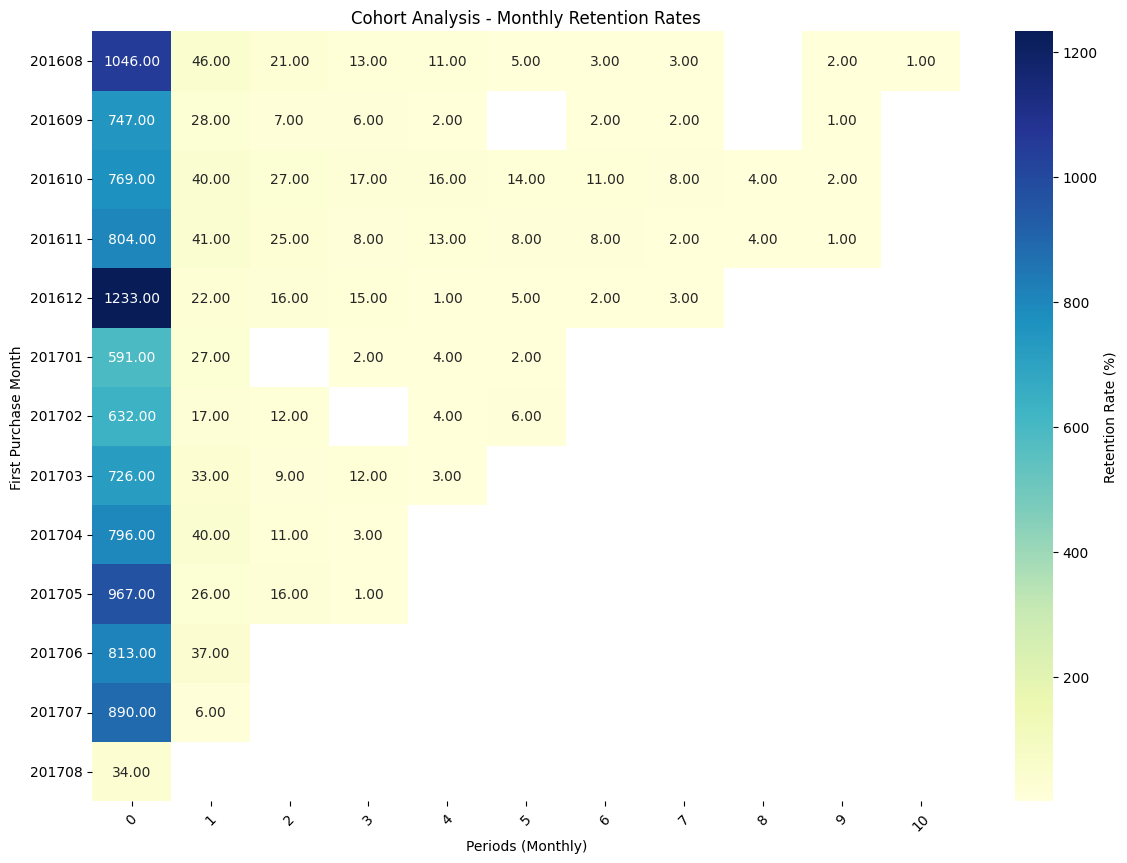

In [ ]:
# FirstPurchaseMonth 열을 인덱스로 설정합니다.
cohort_pivot.set_index('FirstPurchaseMonth', inplace=True)

# 데이터 타입을 확인하고 필요한 경우 숫자형으로 변환합니다.
cohort_pivot = cohort_pivot.astype(float)

# 히트맵으로 시각화
plt.figure(figsize=(14, 10))
sns.heatmap(cohort_pivot, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Retention Rate (%)'})
plt.title('Cohort Analysis - Monthly Retention Rates')
plt.ylabel('First Purchase Month')
plt.xlabel('Periods (Monthly)')
plt.xticks(np.arange(0.5, len(cohort_pivot.columns)+0.5), cohort_pivot.columns, rotation=45)
plt.yticks(rotation=0)
plt.show()


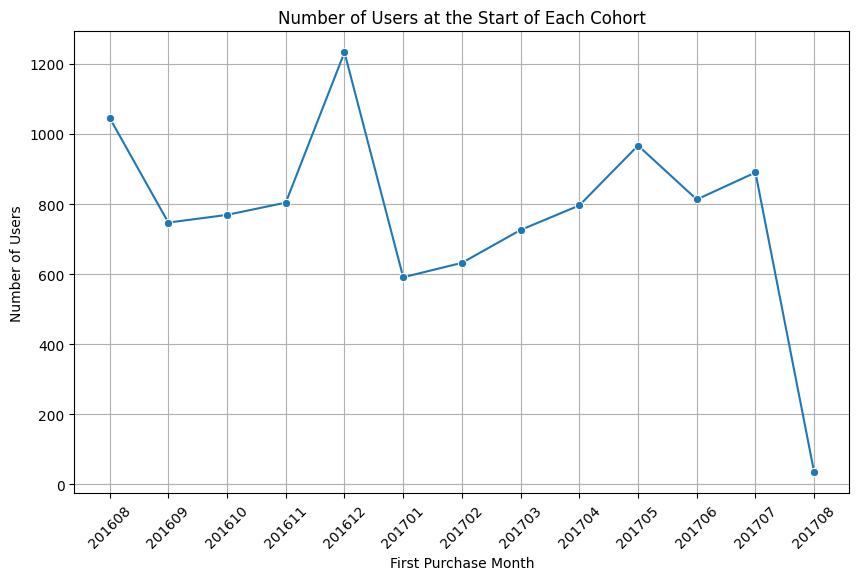

In [ ]:
data = {
    'FirstPurchaseMonth': ['201608', '201609', '201610', '201611', '201612', 
                           '201701', '201702', '201703', '201704', '201705', 
                           '201706', '201707', '201708'],
    '0': [1046, 747, 769, 804, 1233, 591, 632, 726, 796, 967, 813, 890, 34]
}

df = pd.DataFrame(data)

# 'FirstPurchaseMonth' 열을 기반으로 Line Plot 그리기
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='FirstPurchaseMonth', y='0', marker='o')
plt.title('Number of Users at the Start of Each Cohort')
plt.xlabel('First Purchase Month')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

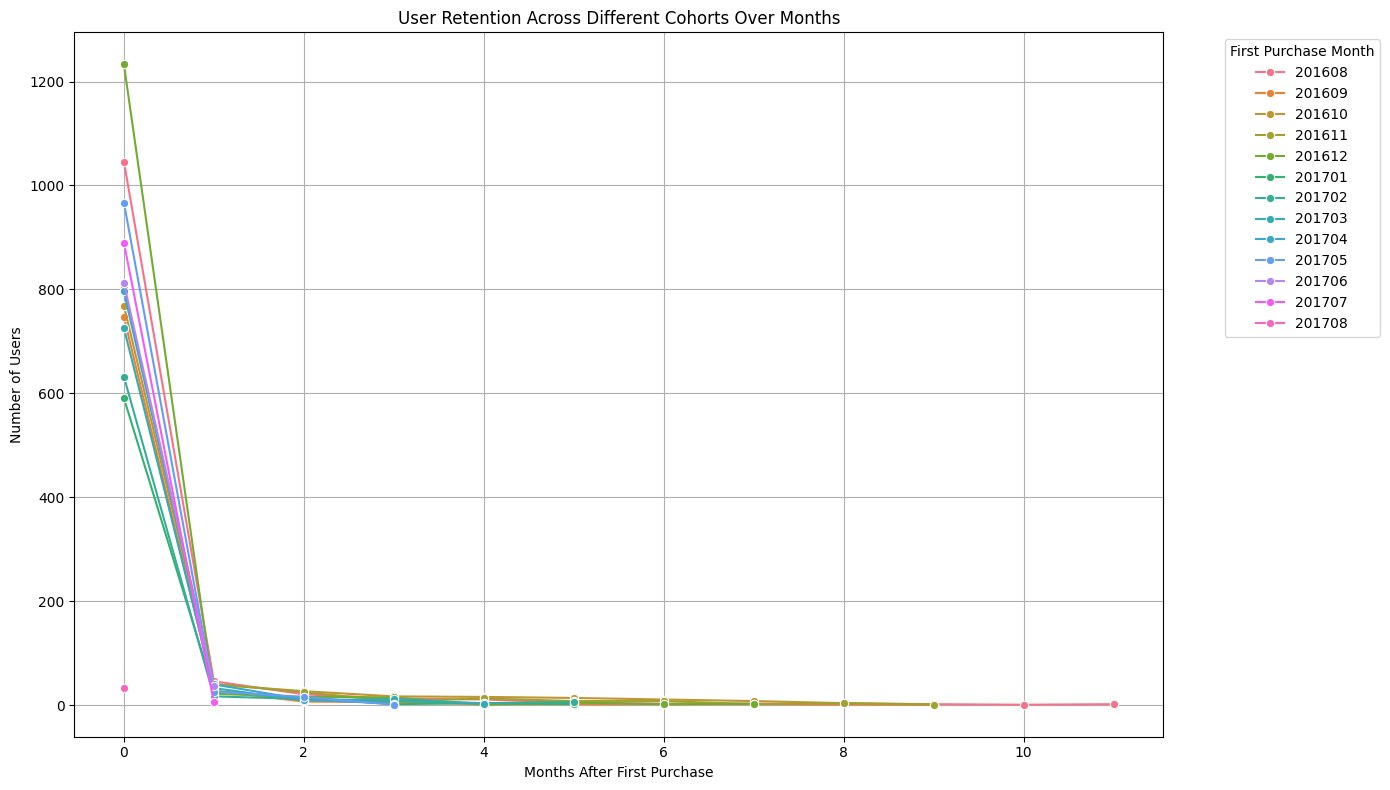

In [ ]:
# 데이터 프레임 생성
df = pd.DataFrame({
    'FirstPurchaseMonth': ['201608', '201609', '201610', '201611', '201612', '201701', '201702', '201703', '201704', '201705', '201706', '201707', '201708'],
    0: [1046, 747, 769, 804, 1233, 591, 632, 726, 796, 967, 813, 890, 34],
    1: [46, 28, 40, 41, 22, 27, 17, 33, 40, 26, 37, 6, np.nan],
    2: [21, 7, 27, 25, 16, np.nan, 12, 9, 11, 16, np.nan, np.nan, np.nan],
    3: [13, 6, 17, 8, 15, 2, np.nan, 12, 3, 1, np.nan, np.nan, np.nan],
    4: [11, 2, 16, 13, 1, 4, 4, 3, np.nan, np.nan, np.nan, np.nan, np.nan],
    5: [5, np.nan, 14, 8, 5, 2, 6, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    6: [3, 2, 11, 8, 2, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    7: [3, 2, 8, 2, 3, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    8: [np.nan, np.nan, 4, 4, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    9: [2, 1, 2, 1, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    10: [1, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    11: [2, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
}).set_index('FirstPurchaseMonth')

# 데이터 프레임을 긴 형태로 변환
df_long = df.reset_index().melt(id_vars='FirstPurchaseMonth', var_name='Month', value_name='Users').dropna()

# 플롯 생성
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_long, x='Month', y='Users', hue='FirstPurchaseMonth', marker='o')
plt.title('User Retention Across Different Cohorts Over Months')
plt.xlabel('Months After First Purchase')
plt.ylabel('Number of Users')
plt.legend(title='First Purchase Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()



<하나의 코호트 내에서 기강네 따른 유지율의 추이>
* 초기에 리텐션이 떨어지는 속도가 급격함 (1 -> 0.0x 수준): 활성화 프로세스가 잘못된 걸까? 왜 재구매율이 떨어지는 걸까? 리마켓팅은 진행하고 있는가?

<서로 다른 코호트의 동일한 기간의 유지율>
첫 번째 결제 기준 다음 달의 결제 유지율:  
* 16년도 하반기: 평균 0.32
* 17년도 상반기: 평균 0.21

<기간에 따른 코호트의 규모>
* 결제자가 유지되는 추세인 것 같다 (201708 제외)

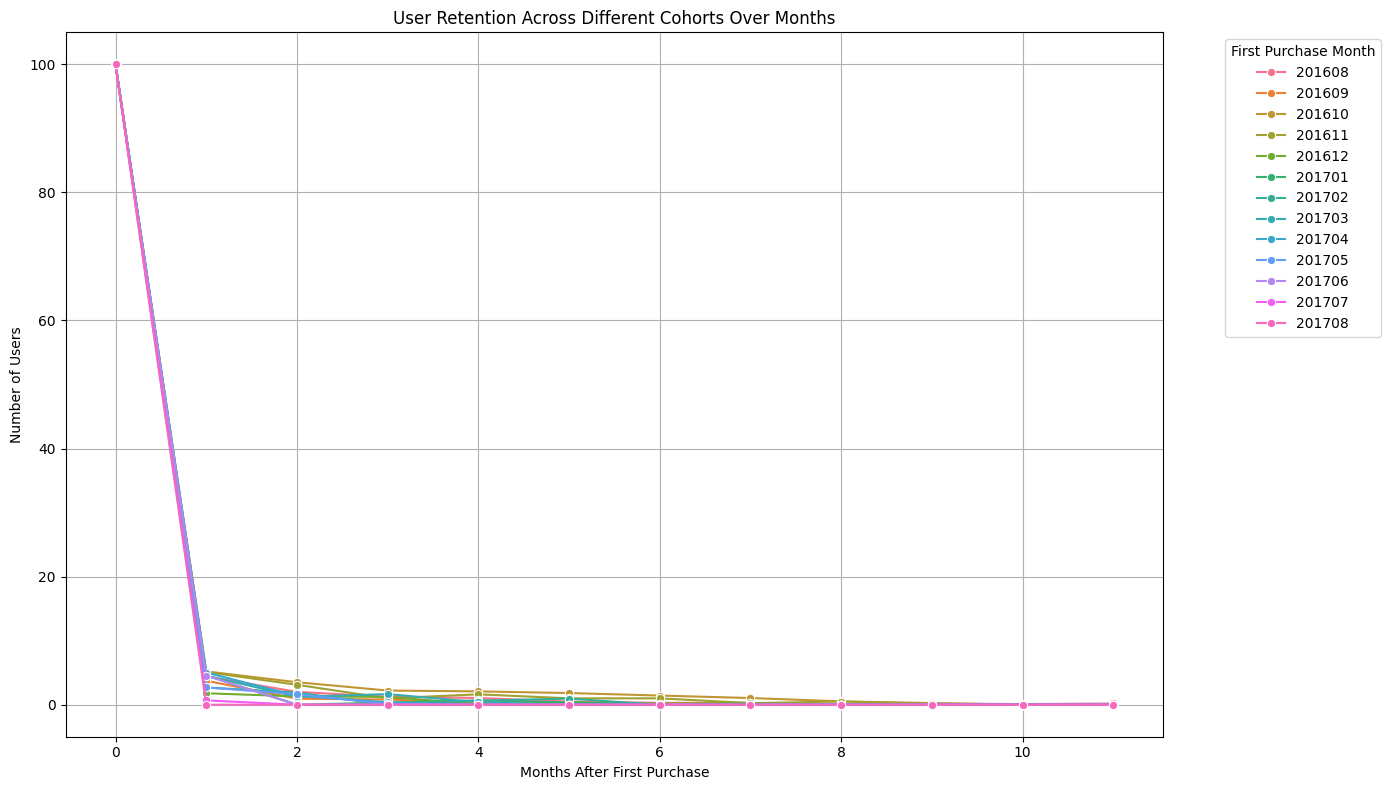

In [ ]:
# DataFrame을 생성하고, NA 값을 0으로 대체합니다.
df = pd.DataFrame({
    'FirstPurchaseMonth': ['201608', '201609', '201610', '201611', '201612', '201701', '201702', '201703', '201704', '201705', '201706', '201707', '201708'],
    0: [1046, 747, 769, 804, 1233, 591, 632, 726, 796, 967, 813, 890, 34],
    1: [46, 28, 40, 41, 22, 27, 17, 33, 40, 26, 37, 6, 0],
    2: [21, 7, 27, 25, 16, 0, 12, 9, 11, 16, 0, 0, 0],
    3: [13, 6, 17, 8, 15, 2, 0, 12, 3, 1, 0, 0, 0],
    4: [11, 2, 16, 13, 1, 4, 4, 3, 0, 0, 0, 0, 0],
    5: [5, 0, 14, 8, 5, 2, 6, 0, 0, 0, 0, 0, 0],
    6: [3, 2, 11, 8, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    7: [3, 2, 8, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0],
    8: [0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    9: [2, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    10: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    11: [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
}).set_index('FirstPurchaseMonth').fillna(0)



# '0' 열 값을 기준으로 각 컬럼의 비율 계산
for column in df.columns[1:]:
    df[column] = (df[column] / df[0]) * 100

# '0' 열의 각 값을 100으로 설정
df[0] = 100

df

# 데이터 프레임을 긴 형태로 변환
df_long = df.reset_index().melt(id_vars='FirstPurchaseMonth', var_name='Month', value_name='Users').dropna()

# 플롯 생성
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_long, x='Month', y='Users', hue='FirstPurchaseMonth', marker='o')
plt.title('User Retention Across Different Cohorts Over Months')
plt.xlabel('Months After First Purchase')
plt.ylabel('Number of Users')
plt.legend(title='First Purchase Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

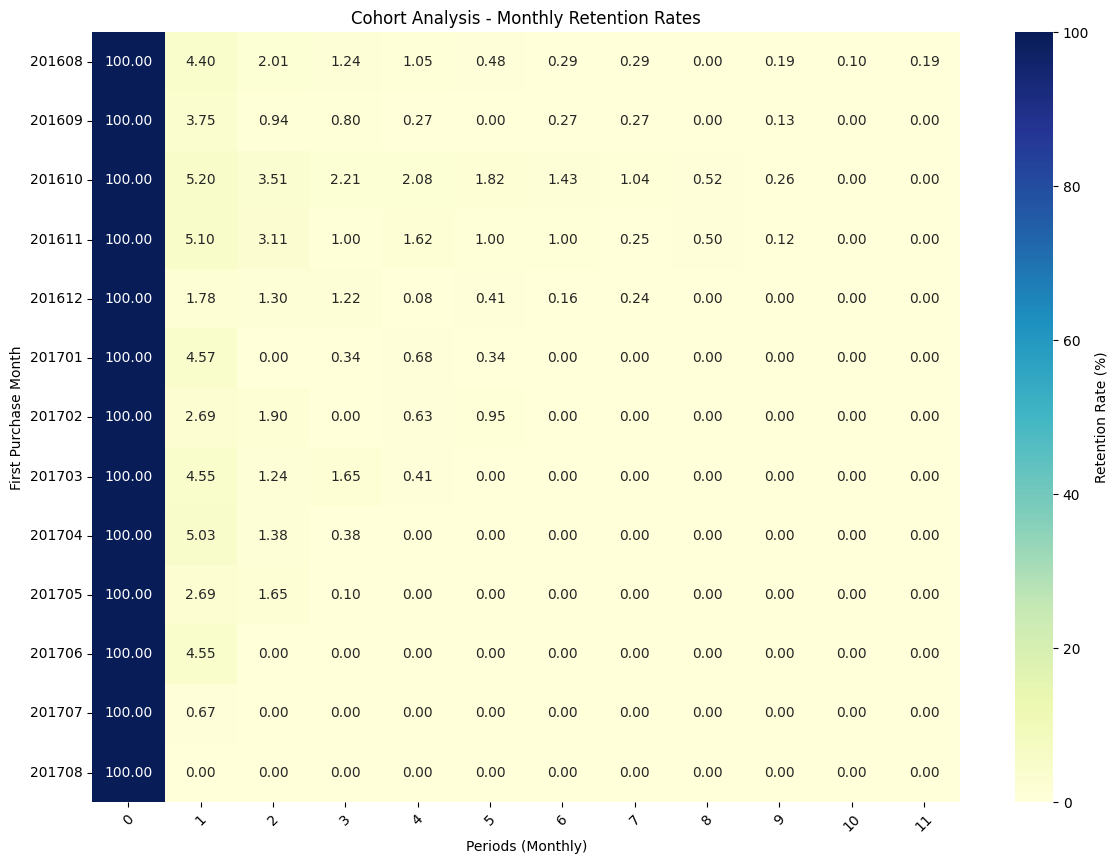

In [ ]:
# 히트맵으로 시각화
plt.figure(figsize=(14, 10))
sns.heatmap(df, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Retention Rate (%)'})
plt.title('Cohort Analysis - Monthly Retention Rates')
plt.ylabel('First Purchase Month')
plt.xlabel('Periods (Monthly)')
plt.xticks(np.arange(0.5, len(df.columns)+0.5), df.columns, rotation=45)
plt.yticks(rotation=0)
plt.show()
